In [1]:
from datetime import date, datetime, time, timedelta
import pysrt
from textblob import TextBlob
import matplotlib 
from matplotlib import style
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
sns.set()
%matplotlib inline
matplotlib.rcParams['figure.figsize']=(16.0,9.0)
style.use('fivethirtyeight')
from decimal import *
import csv
import pandas as pd
import numpy as np
import os
import nltk

The Directories: Subtitles and Scene Segementation

In [2]:
scenes_dir='/home/berhe/Desktop/LIMSI/TLP_thesis/Scenes/'
subtitle_dir='/home/berhe/Desktop/LIMSI/TLP_thesis/subtitles/'

In [3]:
subtitleFiles=[]
for fl in os.listdir(subtitle_dir):
    if '.en.srt' in fl:
       subtitleFiles.append(fl)

scenesegementedFiles=[]
for fl in os.listdir(scenes_dir):
    if 'Episode' in fl:
       scenesegementedFiles.append(fl)

In [4]:
subtitleFiles.sort()
scenesegementedFiles.sort()

In [5]:
def to_min_sec(st_ms,end_ms):
    Ssec=st_ms/1000
    Esec=end_ms/1000
    sm,ss=divmod(Ssec,60)
    em,es=divmod(Esec,60)
    return sm,ss,em,es

In [6]:
import re
def clean_str(string):
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", "", string)
    string = re.sub(r"\'s", "\'s", string)
    string = re.sub(r"\'ve", "\'ve", string)
    string = re.sub(r"n\'t", "n\'t", string)
    string = re.sub(r"\'re", "\'re", string)
    string = re.sub(r"\'d", "\'d", string)
    string = re.sub(r"\'ll", "\'ll", string)
    string = re.sub(r",", ",", string)
    string = re.sub(r"!", "!", string)
    string = re.sub("([\(\[]).*?([\)\]])", "", string)
    #string = re.sub(r")", r"", string)
    #string = re.sub(r"\?", " \? ", string)
    #string = re.sub(r"\s{2,}", " ", string)
    return string.strip()#.lower()

In [7]:
def scene_extraction(fileName):
    fileName=open(fileName,'r')
    text=fileName.readlines()
    start_scene=[]
    end_scene=[]
    story_id=[]
    for text_line in text:
        if not text_line in ['\n', '\r\n']:
            splitte_lines=text_line.split()
            try:
                start_scene.append(splitte_lines[0])
                end_scene.append(splitte_lines[1])
                story_id.append(splitte_lines[2])
            except IndexError:
                story_id.append('NA')
        else:
            continue
    return start_scene,end_scene,story_id

In [8]:
x,y,z=scene_extraction(scenes_dir+scenesegementedFiles[0])

In [9]:
len(x)

35

In [10]:
def sceneTexts(scenesegementedFiles,subtitleFiles):
    scenesegementedFiles.sort()
    subtitleFiles.sort()
    part_st=""
    scene_texts=[]
    scene_lbls=[]
    for j in range(len(scenesegementedFiles)):
        start,end,story_id=scene_extraction(scenes_dir+scenesegementedFiles[j])
        subs=pysrt.open(subtitle_dir+subtitleFiles[j],encoding='iso-8859-1')
        start=[float(i) for i in start]
        end=[float(i) for i in end]
        for i in range(len(start)):
            m,s,em,es=to_min_sec(start[i],end[i])
            part_st=subs.slice(starts_after={'minutes': m, 'seconds':s}, ends_before={'minutes': em, 'seconds': es}).text.encode('utf-8')
            scene_texts.append(part_st)
            scene_lbls.append(story_id[i])
            #if (story_id[i]==story_id[i+1]):
             #  part_st=part_st + subs.slice(starts_after={'minutes': m, 'seconds':s}, ends_before={'minutes': em, 'seconds': es}).text.encode('utf-8')
            #else:
             #   part_st=part_st + subs.slice(starts_after={'minutes': m, 'seconds':s}, ends_before={'minutes': em, 'seconds': es}).text.encode('utf-8')
              #  text_file.write(part_st)
               # text_file.write("\n------------------------------------------------------------------------\n")
                #part_st=""
    return scene_texts,scene_lbls

In [11]:
sc_txt,sc_lbl=sceneTexts(scenesegementedFiles=scenesegementedFiles,subtitleFiles=subtitleFiles)

In [12]:
len(sc_txt),len(sc_lbl)

(274, 274)

In [13]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [14]:
tra_data,test_data,tra_lbl,test_lbl=train_test_split(sc_txt,sc_lbl,test_size=0.20)

In [15]:
len(tra_data),len(test_data),len(tra_lbl),len(test_lbl)

(219, 55, 219, 55)

In [16]:
from sklearn.metrics import accuracy_score
import numpy as np

def purity_score(y_true, y_pred):
    # matrix which will hold the majority-voted labels
    y_labeled_voted = np.zeros(y_true.shape)
    labels = np.unique(y_true)
    # We set the number of bins to be n_classes+2 so that 
    # we count the actual occurence of classes between two consecutive bin
    # the bigger being excluded [bin_i, bin_i+1[
    bins = np.concatenate((labels, [np.max(labels)+1]), axis=0)

    for cluster in np.unique(y_pred):
        hist, _ = np.histogram(y_true[y_pred==cluster], bins=bins)
        # Find the most present label in the cluster
        winner = np.argmax(hist)
        y_labeled_voted[y_pred==cluster] = winner

    return accuracy_score(y_true, y_labeled_voted)

TF-IDF based

In [213]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
 
#documents = ["This little kitty came to play when I was eating at a restaurant.",
            # "Merley has the best squooshy kitten belly.",
            # "Google Translate app is incredible.",
            # "If you open 100 tab in google you get a smiley face.",
             #"Best cat photo I've ever taken.",
             #"Climbing ninja cat.",
             #"Impressed with google map feedback.",
             #"Key promoter extension for Google Chrome."]
documents=tra_data
 
 
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_vector = vectorizer.fit_transform(documents).todense()
 
true_k = 10
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
cluster_labels1=model.fit_predict(tfidf_vector)
 
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:  army  mud  savages  ii  dothraki  people  advising  twigs  conquer  horselords
Cluster 1:  lord  ll  king  don  man  know  father  did  want  ve
Cluster 2:  oasierly  house  duty  rock  father  bran  represent  nickering  chirping  attacked
Cluster 3:  faces  looking  maneilous  decorating  interesting  distinctive  spikes  write  halfrnan  face
Cluster 4:  ink  table  paper  write  say  gifted  gives  given  girls  girlhood
Cluster 5:  donâ  robb  hodor  welcome  winterfell  watch  hall  cooped  visitors  hodorl
Cluster 6:  suit  straws  knights  ago  wants  seen  king  chuckles  life  drawâ
Cluster 7:  peace  joffrey  cloaks  proclaims  make  stannis  heir  need  unless  throne
Cluster 8:  white  walkers  impacting  laughing  bran  deserter  law  oath  beautiful  thank
Cluster 9:  said  lyingl  promised  fat  arya  bastard  sighs  stop  didn  kill


In [214]:
for i in range(len(tra_data)):
    #print (test_data[i])
    print("Prediction")
    Y = vectorizer.transform([tra_data[i]])
    prediction = model.predict(Y)
    print(prediction),
    print[tra_lbl[i]]

Prediction
[1] ['2']
Prediction
[1] ['2']
Prediction
[1] ['0']
Prediction
[1] ['1']
Prediction
[1] ['2']
Prediction
[1] ['NA']
Prediction
[1] ['2']
Prediction
[1] ['1']
Prediction
[1] ['3']
Prediction
[1] ['NA']
Prediction
[1] ['0']
Prediction
[1] ['NA']
Prediction
[1] ['3']
Prediction
[8] ['0']
Prediction
[1] ['0']
Prediction
[1] ['0']
Prediction
[1] ['1']
Prediction
[1] ['NA']
Prediction
[1] ['0']
Prediction
[1] ['NA']
Prediction
[1] ['0']
Prediction
[1] ['3']
Prediction
[1] ['2']
Prediction
[1] ['3']
Prediction
[1] ['2']
Prediction
[1] ['3']
Prediction
[1] ['3']
Prediction
[1] ['2']
Prediction
[1] ['1']
Prediction
[1] ['NA']
Prediction
[1] ['2']
Prediction
[1] ['NA']
Prediction
[1] ['1']
Prediction
[1] ['3']
Prediction
[1] ['0']
Prediction
[1] ['2']
Prediction
[1] ['0']
Prediction
[1] ['3']
Prediction
[1] ['2']
Prediction
[1] ['0']
Prediction
[1] ['3']
Prediction
[1] ['3']
Prediction
[1] ['0']
Prediction
[1] ['2']
Prediction
[9] ['0']
Prediction
[1] ['NA']
Prediction
[1] ['2']
Predi

In [215]:
len(cluster_labels1),len(tra_lbl)

(219, 219)

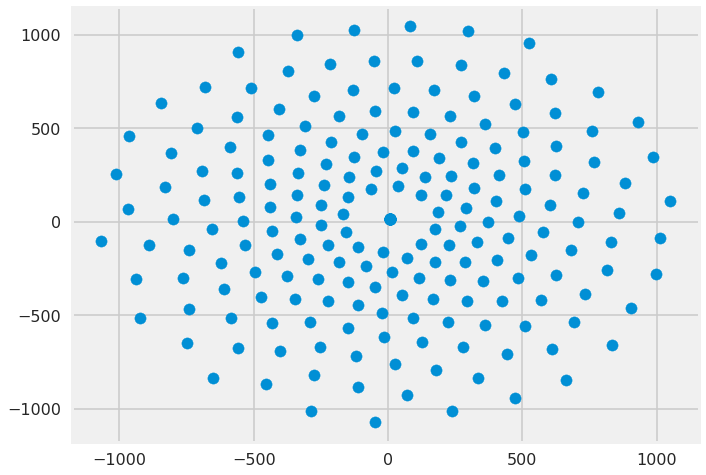

In [216]:
tsne_init = 'pca'  # could also be 'random'
tsne_perplexity = 10.0
tsne_early_exaggeration = 4.0
tsne_learning_rate = 1000
random_state = 1
model_pca = TSNE(n_components=2, random_state=random_state, init=tsne_init, perplexity=tsne_perplexity,
         early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)

transformed_vector = model_pca.fit_transform(tfidf_vector)
#print (transformed_centroids)
plt.figure(figsize=(10,8))
plt.scatter(transformed_vector[:, 0], transformed_vector[:, 1])
plt.show()

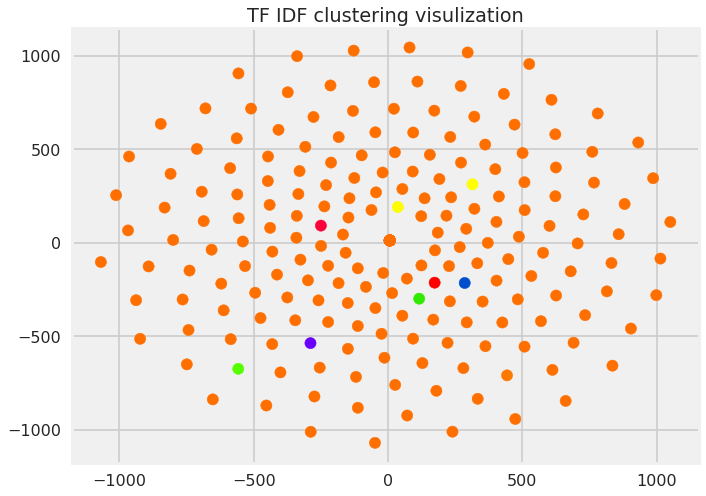

In [217]:
plt.figure(figsize=(10,8))
plt.title('TF IDF clustering visulization')
plt.scatter(transformed_vector[:,0],transformed_vector[:,1],c=cluster_labels1,cmap='prism')
plt.show()

In [218]:
print('accuracy using tf_idf vector', metrics.adjusted_rand_score(cluster_labels1, tra_lbl)) 

('accuracy using tf_idf vector', -0.0057280118230003865)


In [219]:
print('Purity is ',purity_score(cluster_labels1, tra_lbl))

('Purity is ', 0.0045662100456621)


In [220]:
print('Normalize mutual information: ',metrics.normalized_mutual_info_score(cluster_labels1, tra_lbl))

('Normalize mutual information: ', 0.09430397222019693)


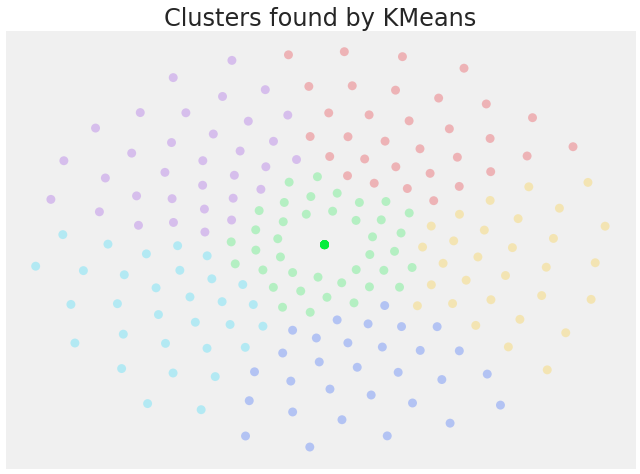

In [221]:
tf_idf_clust=plot_clusters(transformed_vector, cluster.KMeans, (), {'n_clusters':6})

In [222]:
print('accuracy using tf_idf vector', metrics.adjusted_rand_score(tf_idf_clust, tra_lbl)) 
print('Purity is ',purity_score(tf_idf_clust, tra_lbl))
print('Normalize mutual information: ',metrics.normalized_mutual_info_score(tf_idf_clust, tra_lbl))

('accuracy using tf_idf vector', 0.023098746341936583)
('Purity is ', 0.136986301369863)
('Normalize mutual information: ', 0.07732088372414032)


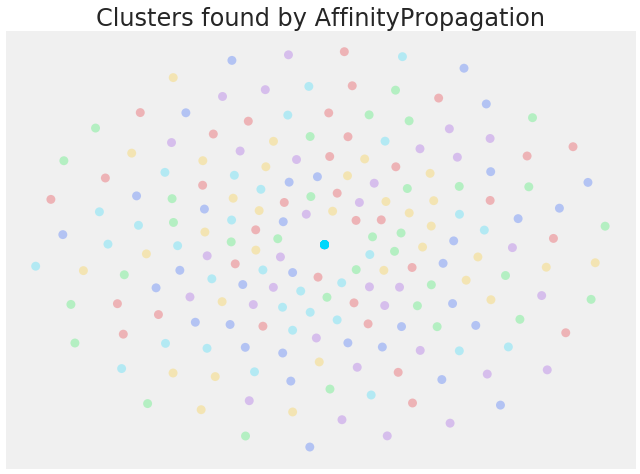

In [203]:
tf_idf_clust1=plot_clusters(transformed_vector, cluster.AffinityPropagation, (), {'preference':-5.0, 'damping':0.95})

In [205]:
print('accuracy using tf_idf vector', metrics.adjusted_rand_score(tf_idf_clust1, tra_lbl)) 
print('Purity is ',purity_score(tf_idf_clust1, tra_lbl))
print('Normalize mutual information: ',metrics.normalized_mutual_info_score(tf_idf_clust1, tra_lbl))

('accuracy using tf_idf vector', 0.04208059900419787)
('Purity is ', 0.0045662100456621)
('Normalize mutual information: ', 0.5454896653409572)


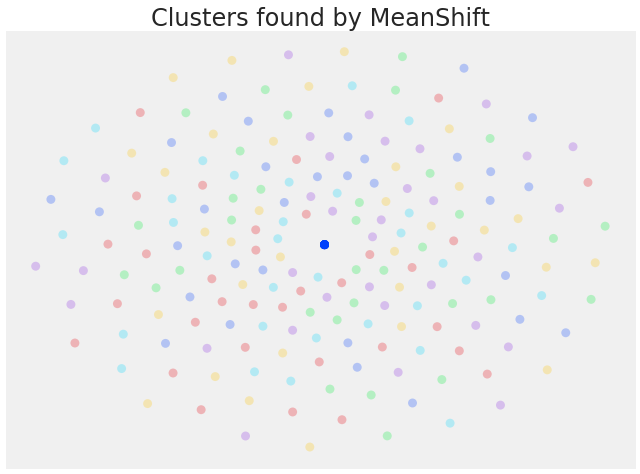

In [206]:
tf_idf_clust2=plot_clusters(transformed_vector,cluster.MeanShift, (0.175,), {'cluster_all':False})

In [207]:
print('accuracy using tf_idf vector', metrics.adjusted_rand_score(tf_idf_clust2, tra_lbl)) 
print('Purity is ',purity_score(tf_idf_clust2, tra_lbl))
print('Normalize mutual information: ',metrics.normalized_mutual_info_score(tf_idf_clust2, tra_lbl))

('accuracy using tf_idf vector', 0.04216679306818318)
('Purity is ', 0.1095890410958904)
('Normalize mutual information: ', 0.547309196836787)


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

In [142]:
def plot_clusters(data, algorithm, args, kwds):
    #start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    #end_time = time.time()
    #acc=metrics.adjusted_rand_score(labels, tra_lbl)
    palette = sns.color_palette('bright', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.figure(figsize=(10,8))
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    #plt.suptitle('accuracy is {}'.format(str(acc)))
    #plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    return labels

In [30]:
cls_list=list(cluster_labels1)

In [31]:
cls_lbl=set(cls_list)
sum=0
for j in cls_lbl:
    print(j, cls_list.count(j))
    sum=sum+cls_list.count(j)
print ('the sum is', sum)

(0, 1)
(1, 1)
(2, 209)
(3, 1)
(4, 2)
(5, 1)
(6, 1)
(7, 1)
(8, 1)
(9, 1)
('the sum is', 219)


In [32]:
trlbl=set(tra_lbl)
sum=0
for i in trlbl:
    print(i,tra_lbl.count(i))
    sum=sum+tra_lbl.count(i)
print ('the sum is', sum)

('NA', 30)
('1', 33)
('0', 60)
('3', 35)
('2', 51)
('5', 1)
('4', 9)
('the sum is', 219)


In [33]:
for i in range(10):
    print(test_data[i])
    print('--------------------------'),
    print(test_lbl[i])

The brave men didn't kill dragons.
The brave men rode them.
Rode them from Valyria
to build the greatest civilization
this world has ever seen.
The breath of the greatest dragon
forged the Iron Throne,
which the Usurper is
keeping warm for me.
The swords of the vanquished,
a thousand of them...
melted together
like so many ndles.
I have always wanted
to see a dragon.
There's nothing in the world
that I would rather see.
Really. Why dragons?
They n ï¬y.
And wherever they are,
just a few ï¬aps of their wings
and they're somewhere else...
far away.
And they n kill.
Anyone or anything
that tries to hurt them
- gets burned away to nothing...
- (Gasm)
..melted...
like so many ndles.
ON.
Yes. Seeing a dragon
would make me very happy.
Well, after 15 years
in a pleasure house,
I imagine just seeing the sky
makes you happy.
I was not locked in.
I have seen things.
- What have you seen?
- I've seen...
a man from Asshai
with a dagger of real dragonglass.
- Ooh.
- I've seen a man who could
change

In [34]:
Y = vectorizer.transform(["They're savages. One lot steals a goat from another lot, before you know it they're ripping each other to pieces"])
prediction = model.predict(Y)
print(prediction)

[2]


In [35]:
Y = vectorizer.transform(["Lannisters don't act like fools now help me keep the damn thing."])
prediction = model.predict(Y)
print(prediction)

[2]


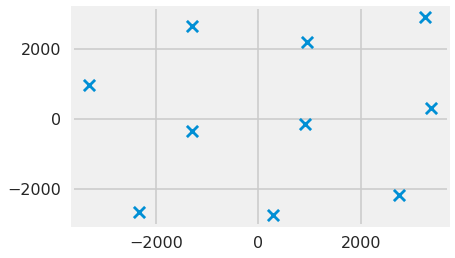

In [36]:
from sklearn.manifold import TSNE
centroids = model.cluster_centers_
tsne_init = 'pca'  # could also be 'random'
tsne_perplexity = 10.0
tsne_early_exaggeration = 4.0
tsne_learning_rate = 1000
random_state = 1
model1 = TSNE(n_components=2, random_state=random_state, init=tsne_init, perplexity=tsne_perplexity,
         early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)

transformed_centroids = model1.fit_transform(centroids)
#print (transformed_centroids)
plt.scatter(transformed_centroids[:, 0], transformed_centroids[:, 1], marker='x')
plt.show()

Vector Count 

In [37]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import ward, dendrogram

In [38]:
vectorizer = CountVectorizer(input='content')
dtm = vectorizer.fit_transform(tra_data)
vocab = vectorizer.get_feature_names()

In [39]:
dtm.shape

(219, 3731)

In [40]:
dtm=dtm.toarray()
vocab=np.array(vocab)

In [41]:
snow_idx = list(vocab).index('snow')
snow_idx

2972

In [42]:
n, _ = dtm.shape
dist_eclud = np.zeros((n, n))

In [43]:
dist_eclud = euclidean_distances(dtm)

In [44]:
for i in range(n):
    for j in range(n):
        x, y = dtm[i, :], dtm[j, :]
        dist_eclud[i, j] = np.sqrt(np.sum((x - y)**2))

In [45]:
np.round(dist_eclud, 1)

array([[ 0. ,  6.3, 18.4, ..., 22. , 53.9, 14.2],
       [ 6.3,  0. , 17.9, ..., 21.1, 52.4, 14. ],
       [18.4, 17.9,  0. , ..., 23.1, 45.8, 17.1],
       ...,
       [22. , 21.1, 23.1, ...,  0. , 46.9, 21.9],
       [53.9, 52.4, 45.8, ..., 46.9,  0. , 48.8],
       [14.2, 14. , 17.1, ..., 21.9, 48.8,  0. ]])

In [46]:
import os
import matplotlib.pyplot as plt
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos=mds.fit_transform(dist_eclud)

In [47]:
xs,ys=pos[:, 0],pos[:,1]

In [48]:
names=['story 1','story 2','story 3','story 4','story 5','story 6']

<function matplotlib.pyplot.show>

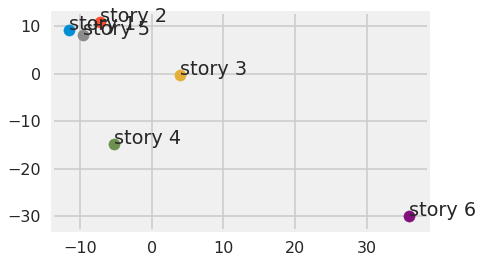

In [49]:
for x, y, name in zip(xs, ys, names):
    plt.scatter(x, y)
    plt.text(x, y, name)
    
plt.show

In [50]:
cos_sim = 1 - cosine_similarity(dtm)

In [51]:
cos_sim.shape

(219, 219)

In [52]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos=mds.fit_transform(cos_sim)
xs,ys=pos[:, 0],pos[:,1]

<function matplotlib.pyplot.show>

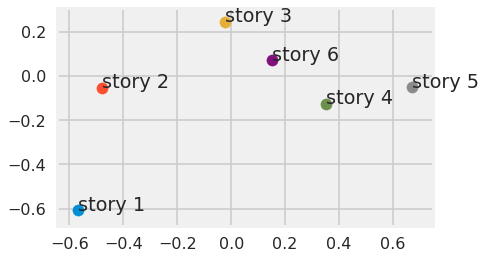

In [53]:
for x, y, name in zip(xs, ys, names):
    plt.scatter(x, y)
    plt.text(x, y, name)
    
plt.show

In [54]:
mds = MDS(n_components=3, dissimilarity="precomputed", random_state=1)
pos1=mds.fit_transform(cos_sim)

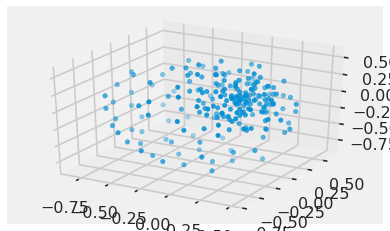

In [55]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos1[:, 0], pos1[:, 1], pos1[:, 2])

In [123]:
from scipy.cluster.hierarchy import ward, dendrogram,complete
link_matr=ward(dtm)

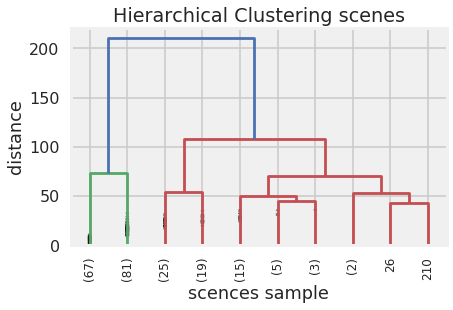

In [124]:
plt.title('Hierarchical Clustering scenes')
plt.xlabel('scences sample')
plt.ylabel('distance')
dendrogram(link_matr,truncate_mode='lastp',leaf_rotation=90,leaf_font_size=12,p=10,show_contracted=True)
plt.show()

In [125]:
from scipy.cluster.hierarchy import fcluster
clusters=fcluster(link_matr,5,depth=20)
clusters

array([1, 1, 3, 3, 1, 4, 1, 2, 2, 3, 2, 1, 1, 2, 4, 3, 1, 1, 2, 1, 4, 3,
       4, 3, 1, 2, 4, 1, 1, 1, 1, 1, 4, 3, 2, 2, 4, 3, 2, 1, 4, 3, 1, 1,
       1, 1, 3, 1, 2, 2, 2, 2, 2, 1, 2, 1, 3, 2, 4, 4, 1, 2, 1, 3, 1, 2,
       2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 2, 2, 3, 3, 4, 2, 3, 1, 3, 2,
       2, 1, 2, 2, 2, 3, 4, 2, 3, 4, 2, 1, 3, 3, 2, 4, 1, 2, 2, 2, 1, 2,
       4, 3, 4, 2, 1, 2, 4, 2, 2, 2, 1, 3, 2, 2, 2, 2, 3, 1, 2, 1, 1, 2,
       3, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 2, 4, 3, 3, 2, 1, 2, 2, 3, 1,
       1, 3, 1, 2, 4, 4, 1, 1, 2, 1, 3, 2, 1, 2, 2, 3, 1, 1, 2, 2, 2, 1,
       2, 4, 1, 2, 3, 2, 3, 1, 4, 3, 2, 4, 1, 2, 2, 1, 3, 1, 1, 2, 3, 4,
       1, 1, 2, 1, 2, 4, 2, 2, 1, 2, 3, 1, 4, 2, 1, 3, 3, 1, 2, 4, 2],
      dtype=int32)

In [126]:
len(clusters),len(tra_lbl),len(link_matr),len(cos_sim)

(219, 219, 218, 219)

In [127]:
print("accuracy of the cluster ",metrics.adjusted_rand_score(clusters,tra_lbl))

('accuracy of the cluster ', 0.051486313589248635)


In [128]:
print('the purrity score ',purity_score(clusters, tra_lbl))

('the purrity score ', 0.0)


In [129]:
print('Normalize mutual information: ',metrics.normalized_mutual_info_score(clusters, tra_lbl))

('Normalize mutual information: ', 0.09443226228569665)


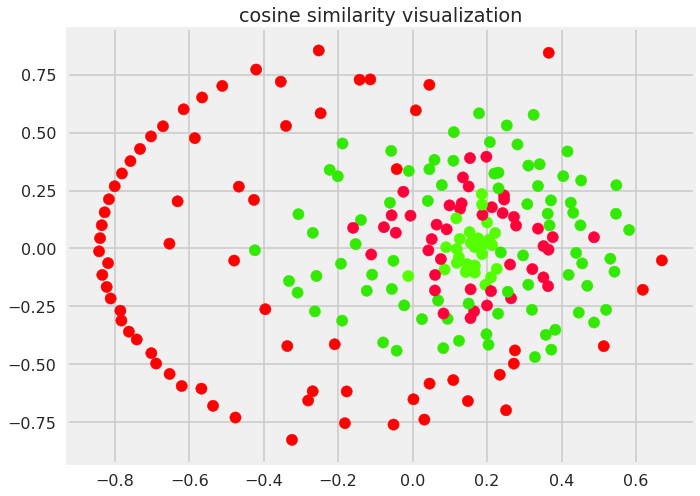

In [130]:
plt.figure(figsize=(10,8))
plt.title('cosine similarity visualization')
plt.scatter(pos[:,0],pos[:,1],c=clusters,cmap='prism')
plt.show()

In [131]:
cl=list(clusters)

In [132]:
for i in set(cl):
    print (i, cl.count(i))

(1, 67)
(2, 81)
(3, 44)
(4, 27)


In [133]:
clusters

array([1, 1, 3, 3, 1, 4, 1, 2, 2, 3, 2, 1, 1, 2, 4, 3, 1, 1, 2, 1, 4, 3,
       4, 3, 1, 2, 4, 1, 1, 1, 1, 1, 4, 3, 2, 2, 4, 3, 2, 1, 4, 3, 1, 1,
       1, 1, 3, 1, 2, 2, 2, 2, 2, 1, 2, 1, 3, 2, 4, 4, 1, 2, 1, 3, 1, 2,
       2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 2, 2, 3, 3, 4, 2, 3, 1, 3, 2,
       2, 1, 2, 2, 2, 3, 4, 2, 3, 4, 2, 1, 3, 3, 2, 4, 1, 2, 2, 2, 1, 2,
       4, 3, 4, 2, 1, 2, 4, 2, 2, 2, 1, 3, 2, 2, 2, 2, 3, 1, 2, 1, 1, 2,
       3, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 2, 4, 3, 3, 2, 1, 2, 2, 3, 1,
       1, 3, 1, 2, 4, 4, 1, 1, 2, 1, 3, 2, 1, 2, 2, 3, 1, 1, 2, 2, 2, 1,
       2, 4, 1, 2, 3, 2, 3, 1, 4, 3, 2, 4, 1, 2, 2, 1, 3, 1, 1, 2, 3, 4,
       1, 1, 2, 1, 2, 4, 2, 2, 1, 2, 3, 1, 4, 2, 1, 3, 3, 1, 2, 4, 2],
      dtype=int32)

In [134]:
link_matr2=complete(dist_eclud)

In [135]:
clusters_ecl=fcluster(link_matr2,5,depth=10)
clusters_ecl

array([2, 2, 4, 5, 2, 6, 2, 3, 4, 5, 4, 2, 2, 4, 1, 1, 2, 2, 5, 2, 6, 1,
       1, 5, 2, 3, 6, 2, 2, 2, 2, 2, 1, 5, 3, 3, 6, 5, 4, 2, 6, 1, 2, 2,
       2, 2, 1, 2, 4, 3, 3, 4, 5, 2, 4, 2, 1, 5, 6, 6, 2, 3, 2, 5, 2, 4,
       3, 1, 1, 5, 5, 3, 3, 3, 4, 4, 2, 2, 3, 3, 5, 5, 6, 5, 1, 2, 4, 4,
       4, 2, 4, 3, 3, 1, 1, 3, 5, 1, 3, 2, 5, 5, 3, 6, 2, 4, 4, 3, 2, 4,
       1, 5, 1, 3, 2, 3, 6, 4, 3, 4, 2, 1, 3, 3, 4, 4, 5, 2, 3, 2, 2, 3,
       1, 2, 2, 3, 1, 2, 1, 2, 3, 2, 3, 5, 4, 1, 6, 1, 3, 2, 3, 3, 1, 2,
       2, 1, 2, 4, 6, 1, 2, 2, 4, 2, 1, 3, 2, 3, 3, 5, 2, 2, 5, 4, 5, 2,
       4, 6, 2, 4, 1, 4, 5, 2, 1, 5, 3, 6, 2, 4, 4, 2, 5, 2, 2, 4, 1, 6,
       2, 2, 4, 2, 5, 6, 4, 4, 2, 4, 5, 2, 6, 5, 2, 5, 1, 2, 5, 6, 3],
      dtype=int32)

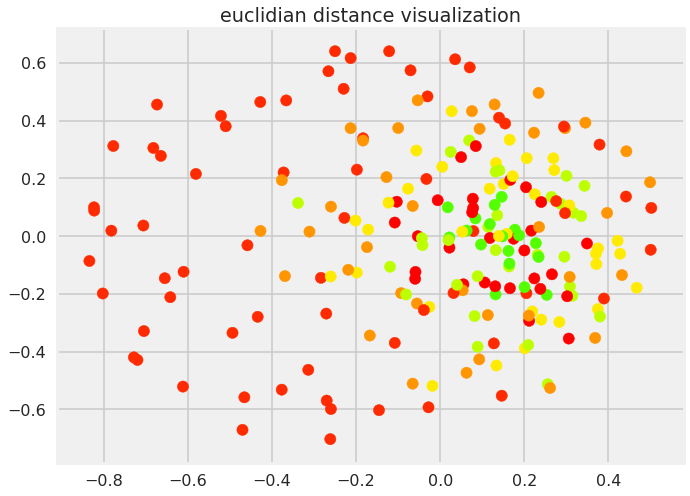

In [136]:
plt.figure(figsize=(10,8))
plt.title('euclidian distance visualization')
plt.scatter(pos1[:,0],pos1[:,1],c=clusters_ecl,cmap='prism')
plt.show()

In [137]:

len(clusters_ecl),len(tra_lbl),len(link_matr)   

(219, 219, 218)

In [138]:
print('accuracy', metrics.adjusted_rand_score(clusters_ecl, tra_lbl)) 

('accuracy', 0.03711680276620171)


In [139]:
print('the purity score is ', purity_score(clusters_ecl,tra_lbl))

('the purity score is ', 0.0)


In [140]:
print('Normalize Mutual Information', metrics.normalized_mutual_info_score(clusters_ecl,tra_lbl))

('Normalize Mutual Information', 0.08336363829046547)


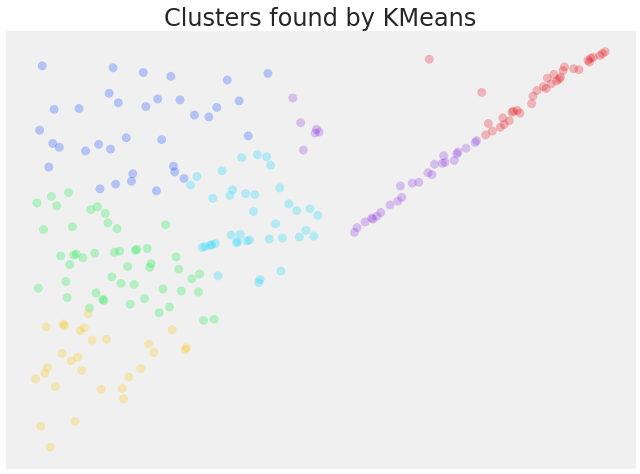

In [143]:
cos_cluster=plot_clusters(link_matr, cluster.KMeans, (), {'n_clusters':6})

In [76]:
len(link_matr)

218

In [144]:
#print("accuracy of the cluster ",metrics.adjusted_rand_score(cos_cluster,tra_lbl))
print('the purity score is ', purity_score(cos_cluster,tra_lbl))

('the purity score is ', 0.16055045871559634)


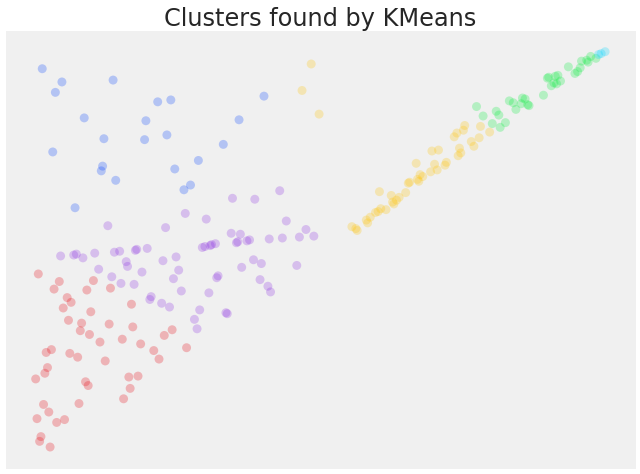

In [145]:
ecl_cluster=plot_clusters(link_matr2, cluster.KMeans, (), {'n_clusters':6})

In [146]:
print('the purity score is ', purity_score(ecl_cluster,tra_lbl))

('the purity score is ', 0.10550458715596331)


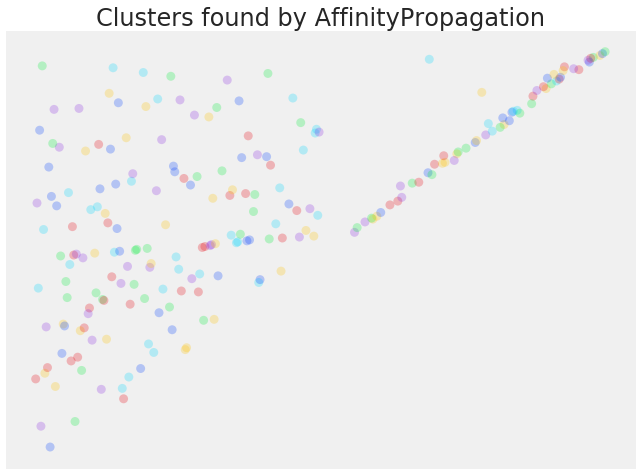

In [147]:
cos_aff_clu=plot_clusters(link_matr, cluster.AffinityPropagation, (), {'preference':-5.0, 'damping':0.95})

In [148]:
print('the purity score is ', purity_score(cos_aff_clu,tra_lbl))

('the purity score is ', 0.0045871559633027525)


In [149]:
len(cos_aff_clu),len(tra_lbl)

(218, 219)

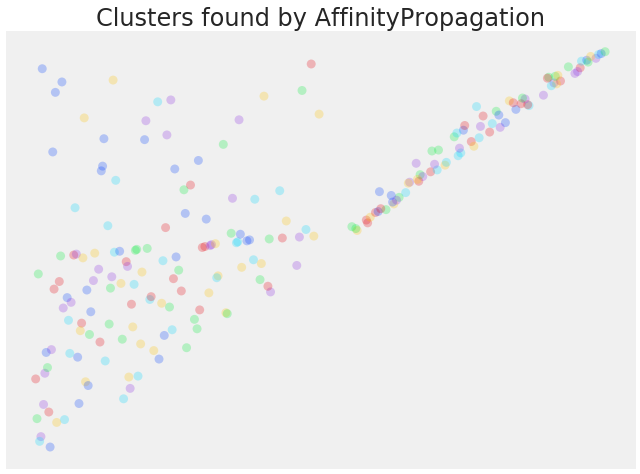

In [150]:
ecl_aff_clu=plot_clusters(link_matr2, cluster.AffinityPropagation, (), {'preference':-5.0, 'damping':0.95})

In [151]:
print('the purity score is ', purity_score(ecl_aff_clu,tra_lbl))

('the purity score is ', 0.0045871559633027525)


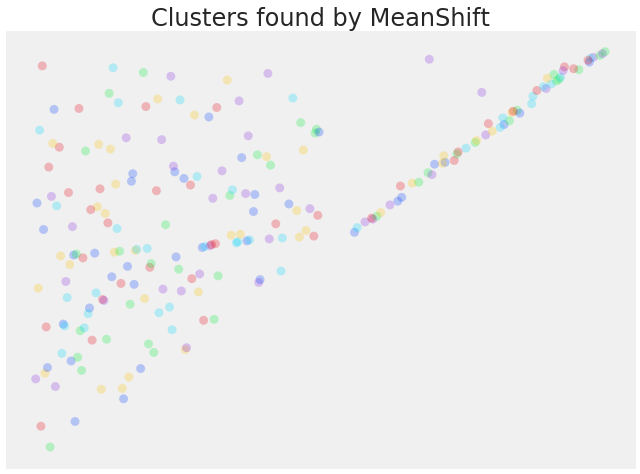

In [152]:
cos_mn_shift=plot_clusters(link_matr, cluster.MeanShift, (0.175,), {'cluster_all':False})

In [153]:
print('the purity score is ', purity_score(cos_mn_shift,tra_lbl))

('the purity score is ', 0.0045871559633027525)


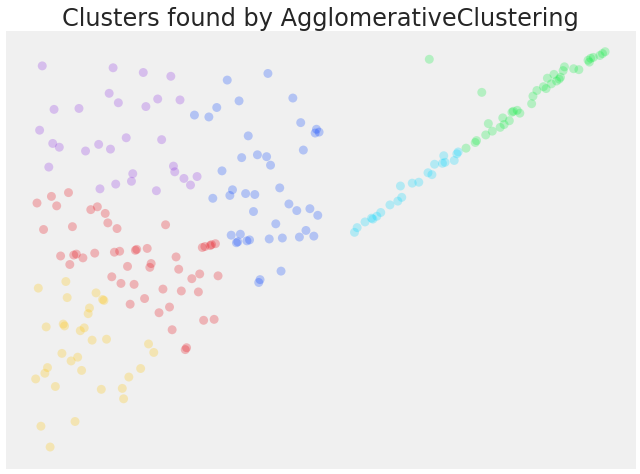

In [154]:
cos_agg_cl=plot_clusters(link_matr, cluster.AgglomerativeClustering, (), {'n_clusters':6, 'linkage':'ward'})

In [155]:
print('the purity score is ', purity_score(cos_agg_cl,tra_lbl))

('the purity score is ', 0.2018348623853211)


In [156]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot

/home/berhe/.virtualenvs/Proj_env/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


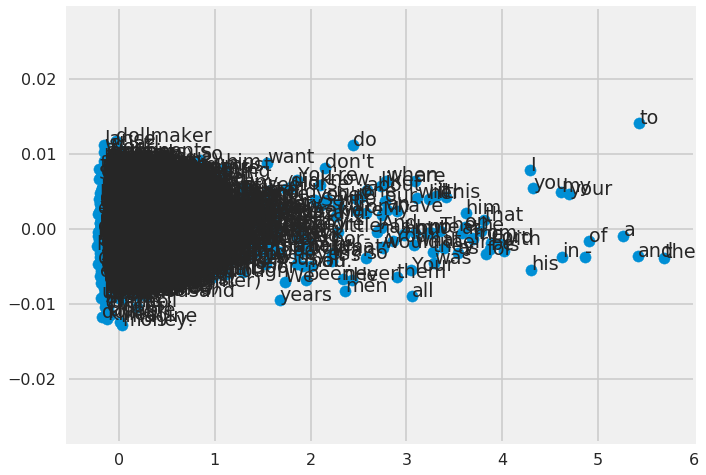

In [157]:
text=""
for i in sc_txt:
    text=text+" "+i
txtblb=TextBlob(text.decode('utf-8'))
sentences=[]
for sent in txtblb.sentences:
    sentences.append(sent.split())
w2vModel=Word2Vec(sentences,min_count=1)
X=w2vModel[w2vModel.wv.vocab]
pca=PCA(n_components=2)
result=pca.fit_transform(X)
words=list(w2vModel.wv.vocab)
pyplot.figure(figsize=(10,8))
pyplot.scatter(result[:, 0],result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i,0], result[i,1]))
pyplot.show()

In [158]:
print(sentences[2])

[u"They're", u'savages.']


In [159]:
X=w2vModel.wv.vectors
modelEmbd = KMeans(n_clusters=6, init='k-means++', max_iter=100, n_init=1)
#modelEmbd.fit(X)
cluster_labels =modelEmbd.fit_predict(X)
print("Top terms per cluster:")
order_centroids = modelEmbd.cluster_centers_.argsort()[:, ::-1]
terms = list(w2vModel.wv.vocab)
for i in range(6):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:  flicking  guardsmen  hurt  horde.  Jorah?  reports  Tonight,  "Counting  (Bird  So...you're
Cluster 1:  flicking  guardsmen  hurt  horde.  Jorah?  reports  Tonight,  "Counting  (Bird  So...you're
Cluster 2:  flicking  guardsmen  hurt  horde.  Jorah?  reports  Tonight,  "Counting  (Bird  So...you're
Cluster 3:  flicking  guardsmen  hurt  horde.  Jorah?  reports  Tonight,  "Counting  (Bird  So...you're
Cluster 4:  flicking  guardsmen  hurt  Jorah?  horde.  reports  Tonight,  "Counting  (Bird  So...you're
Cluster 5:  flicking  guardsmen  hurt  Jorah?  horde.  reports  Tonight,  "Counting  (Bird  So...you're


In [160]:
X.shape

(7652, 100)

In [161]:
print(len(list(w2vModel.wv.vocab)))

7652


In [162]:
from nltk.cluster import KMeansClusterer
X=w2vModel.wv.vectors
kclustere = KMeansClusterer(5, distance=nltk.cluster.util.cosine_distance,repeats=25)
assigned_clusters=kclustere.cluster(X,assign_clusters=True)
print(assigned_clusters)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [163]:
words=list(w2vModel.wv.vocab)
for i, word in enumerate(words):
    print (word + "." +str(assigned_clusters[i]))

"Counting.0
Tonight,.0
Greyjoy.0
(Jeering,.0
(Jeering).0
four.0
Does.0
Untie.0
spiders.0
funl.0
screaming).0
Until.0
marching.0
brothers-in-arms..0
lord.0
flicking.0
innocence..0
Famed.0
horde's.0
advice,.0
(Dogs.0
yellow.0
(Bird.0
horde..0
So...you're.0
disturb.0
Less.0
wooden.0
brutish.0
woods.0
disadvanhge..0
guardsmen.0
Targaryen..0
Targaryen,.0
her..0
her,.0
ate..0
27,.0
Targaryen?.0
elegant.0
second.0
her?.0
valiant.0
sailed.0
strong,".0
understood?.0
thunder.0
nature..0
report..0
hoofbeats).0
hero.0
dirts..0
herl.0
reasons..0
here.0
titles,.0
titles..0
ironies..0
hers.0
Targaryens.0
climbed.0
reports.0
pieces..0
better-looking..0
bellowing).0
Stand.0
golden.0
Iling).0
stewards..0
Three.0
summons.0
brought.0
anywhere..0
stern.0
"The.0
opponents.0
Jorah,.0
Jorah..0
spoke.0
Jorah?.0
untie.0
ï¬shermen.0
apparently..0
until.0
"kingslayer".0
-Sawmewithyourowneyes?.0
hereby.0
show..0
hurt.0
Inform.0
opponent?.0
ï¬aps.0
hold.0
locked.0
(Metal.0
pursue.0
boar....0
blade.0
Boys,.0
(Scra

Neither.0
years?.0
93393).0
Yours?.0
won.4
years,.4
years..0
probably.4
piss.0
upstairs..1
missing.0
Oh..0
happens....4
both.1
from....0
adores.0
wouldn't.0
Sisters.1
dragon's.0
toll..0
protector.0
seeing..0
seeing,.0
liked.0
(Priestess.0
live..0
live,.0
(Mimim).0
whatever.0
likes.0
live?.1
Was.4
War.0
Today?.0
Most.0
damn.0
threaten.0
wait.0
empty.0
Women.4
manner?.0
(Distant.0
steel,.1
packs.0
like..0
climber,.0
wet.0
else.0
lives.0
Pick.0
Conqueror.0
ï¬nger?.0
Hyahl.0
"we".1
look.0
Taste.0
while.0
match.0
costly.1
huh?.0
use..0
use,.3
herein.0
embroidered.0
reads.0
ready.0
rising..0
(Benjen).0
rags?.0
grant.3
belong.0
grand.0
Hadn't.1
here..0
used.4
(Thunder).0
Hound's.0
possession....0
stinks..0
crackling).0
changed..2
older.0
daï¬mess..0
Ten.4
clears.0
chattering).3
dangerous..0
(Whinnying).0
wise..0
reviewed.0
Um,.4
praying.0
double-sided..3
tournaments..0
faster..0
cock..0
march.0
breach?.0
"unless"..0
game.0
wiser.0
judgment..1
Tramping.0
wings.3
signiï¬nt.4
lobster..0
Fish.

persuade.0
(Rustling,.0
crows,.0
creaks).0
creaks,.0
blue.0
strangest.0
change,.0
hide.0
poison.2
leave,.0
leave..3
really..0
hundreds.0
wedding..0
discipline,.4
discipline..0
through..4
Listen....1
worse..0
worse,.1
Sam....0
Mm,.1
Mm..4
worse?.2
settled.0
company..3
mother?.0
Jadi,.2
archery,.0
reply..0
offl.1
would.1
used?.0
Houses.0
Whichever.0
sobered.0
spike.4
slaughtered.0
nothing....0
halfrnan?.0
Ten..0
(Gasps).0
off,.3
rry.0
off..4
abundance.3
Write.0
join.1
Crown.4
House,.0
Crows.0
Where?.0
mp.0
install.4
clacking).3
my.3
House?.1
unspealdable.0
mouth,.0
Isnât.0
undisciplined.2
timel.0
end.0
returning.4
arrnoury..4
that....4
ancestor.0
charging.2
badly.0
both..0
Pycelle.0
mouths.4
warm.0
demanding.0
mouthl.0
criminals..0
Tough.0
lllylio.3
walls?.0
Robb's.0
enter.4
Once,.4
talk?.1
Once..0
Beyond.4
honey's.0
Lamb.0
over.3
expects.0
Ah-ah-ah-ah-ah..0
Yoren.0
Women?.0
monstroust.0
fealty.1
speciï¬m..4
Here.0
ale,.0
fade.1
400.0
expect?.0
Sturdy.0
expect..0
hiring.0
shadows.0
st

In [164]:
lblset=set(assigned_clusters)
for i in lblset:
    print (i,assigned_clusters.count(i))
    

(0, 5470)
(1, 941)
(2, 156)
(3, 310)
(4, 775)


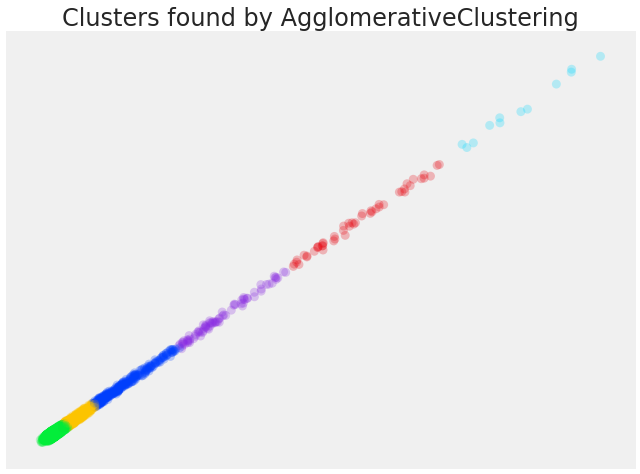

In [165]:
w2v_agg=plot_clusters(X, cluster.AgglomerativeClustering, (), {'n_clusters':6, 'linkage':'ward'})

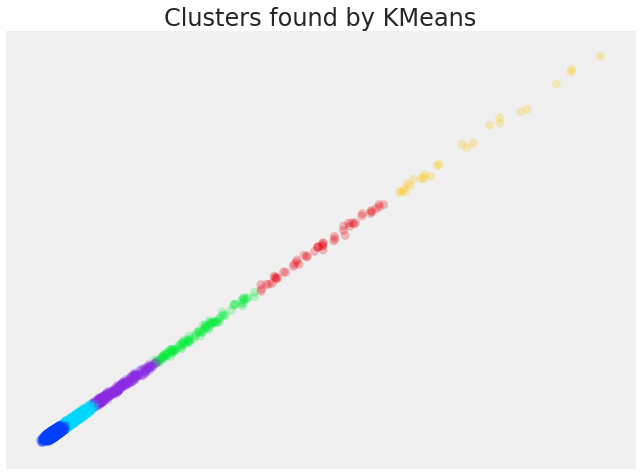

In [168]:
w2v_agg=plot_clusters(X, cluster.KMeans, (), {'n_clusters':6})

Doc2Vec: Documentto Vectors

In [169]:
from gensim.models import doc2vec
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from nltk import word_tokenize
from matplotlib import pyplot
from gensim.models.doc2vec import TaggedDocument

In [170]:
tokenizer = RegexpTokenizer(r'\w+')
stopword_set = set(stopwords.words('english'))

In [171]:
def nlp_clean(data):
   new_data = []
   for d in data:
      #new_str=d.decode('utf-8')
      #new_str = d.lower()
      dlist = tokenizer.tokenize(d)
      dlist = list(set(dlist).difference(stopword_set))
      new_data.append(dlist)
   return new_data

In [172]:
sc_txt1=[x.split() for x in sc_txt]

In [173]:
new_data=nlp_clean(sc_txt)

In [174]:
docs1=[]
for i in sc_txt:
    str_list=i.split()
    T=TaggedDocument(str_list,[i])
    docs1.append(T)

In [175]:
len(docs1)

274

In [176]:
D2V_model = doc2vec.Doc2Vec(docs1, size=100, window=1, min_count=1, workers=1)

/home/berhe/.virtualenvs/Proj_env/local/lib/python2.7/site-packages/gensim/models/doc2vec.py:359: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [177]:
doc_vect=D2V_model.wv.vectors

In [178]:
doc_vect[3]

array([ 8.02280366e-01, -1.44474268e-01, -9.34440717e-02,  1.31375223e-01,
       -2.70855844e-01, -2.37266466e-01, -1.64092511e-01, -8.99400055e-01,
       -2.91633427e-01, -2.05864847e-01,  5.50127983e-01, -2.34014884e-01,
       -3.14202100e-01,  1.20483138e-01,  1.71630353e-01,  2.59811848e-01,
        1.44703135e-01, -2.09330127e-01, -4.38701026e-02, -8.88781101e-02,
        6.31328747e-02,  1.30353898e-01,  6.77300990e-01,  3.39681923e-01,
        6.76591933e-01,  4.79744300e-02,  5.56069613e-01,  2.14980468e-01,
       -9.94797703e-03, -4.39355783e-02, -2.10499078e-01,  1.73626453e-01,
       -3.70111257e-01,  1.56826470e-02,  2.76578784e-01,  3.16384792e-01,
        2.50403970e-01, -2.26984844e-01,  2.13284224e-01, -8.14141110e-02,
       -3.05472732e-01,  7.71353543e-02,  2.07621038e-01, -1.57046355e-02,
       -5.26247025e-01, -2.12575316e-01, -1.65381525e-02,  1.16766244e-01,
        1.28444657e-01,  3.82900923e-01,  3.52066725e-01,  6.25051260e-02,
        2.80707240e-01, -

In [179]:
train_vect=[]
duplicate_dict={}
used_lines=[]
for i, t in enumerate(tra_data):
    duplicate_dict[t]=True
    used_lines.append(t)
    train_vect.append(D2V_model.infer_vector(t))
print('finished doc vectors')

finished doc vectors


In [180]:
len(train_vect),len(tra_data)

(219, 219)

In [181]:
print(train_vect[10])

[ 6.21035755e-01 -1.15171671e-01 -7.26919994e-02  9.87052545e-02
 -2.01832131e-01 -1.78996548e-01 -1.21199235e-01 -6.88546777e-01
 -2.26925552e-01 -1.52463242e-01  4.16238725e-01 -1.80842757e-01
 -2.42292106e-01  9.21972543e-02  1.31826743e-01  1.94047064e-01
  1.17021620e-01 -1.54389590e-01 -4.00417857e-02 -6.74519688e-02
  4.70634662e-02  9.43807811e-02  5.08852720e-01  2.52885431e-01
  5.02289534e-01  2.91637648e-02  4.24862146e-01  1.70113519e-01
 -4.91350098e-03 -3.21078524e-02 -1.56453937e-01  1.25508741e-01
 -2.83144623e-01  1.41301369e-02  2.06394792e-01  2.42845416e-01
  1.89915389e-01 -1.71907037e-01  1.66620508e-01 -5.69053143e-02
 -2.35582426e-01  6.29071966e-02  1.60459980e-01 -9.35968664e-03
 -3.95826697e-01 -1.70801684e-01 -1.24855069e-02  8.72452259e-02
  9.00078118e-02  2.91797519e-01  2.68123448e-01  4.82987612e-02
  2.07681984e-01 -1.22425914e-01 -1.06301375e-01 -4.83531505e-02
 -1.68268472e-01  7.12042376e-02 -7.89811369e-04 -3.81979525e-01
 -1.60612494e-01 -9.46400

In [182]:
train_vect=np.array(train_vect)

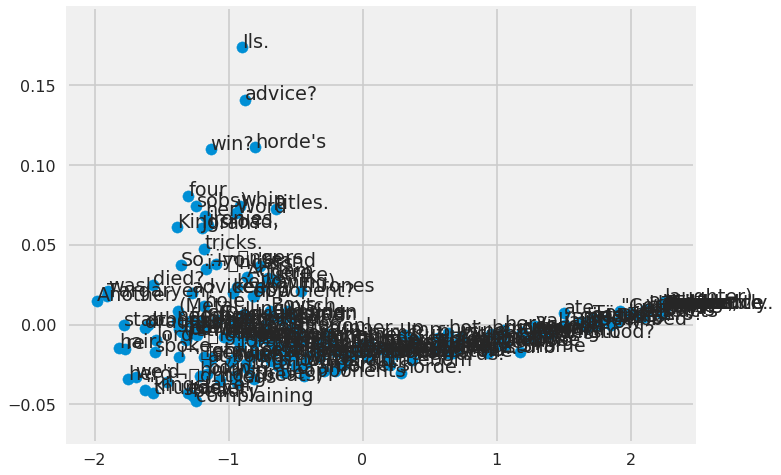

In [183]:
pca1=PCA(n_components=2)
result1=pca1.fit_transform(train_vect)
words=list(D2V_model.wv.vocab)
words=[i.decode('utf-8') for i in words]
pyplot.figure(figsize=(10,8))
pyplot.scatter(result1[:, 0],result1[:, 1])
for i, word in enumerate(words):
    try:
        pyplot.annotate(word, xy=(result1[i,0], result1[i,1]))
    except:
        break
pyplot.show()

In [184]:
len(words)

7652

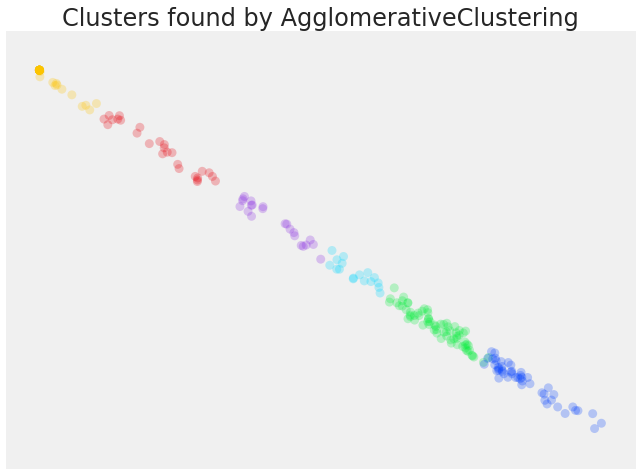

In [185]:
doc2vec_agg=plot_clusters(train_vect, cluster.AgglomerativeClustering, (), {'n_clusters':6, 'linkage':'ward'})

In [186]:
print('accuracy', metrics.adjusted_rand_score(doc2vec_agg, tra_lbl)) 

('accuracy', 0.059638752780946935)


In [187]:
print('the purity score is ', purity_score(doc2vec_agg,tra_lbl))

('the purity score is ', 0.2237442922374429)


In [188]:
print('Normalize Mutual Information', metrics.normalized_mutual_info_score(doc2vec_agg,tra_lbl))

('Normalize Mutual Information', 0.12741868643650023)


In [189]:
train_vect.shape

(219, 100)

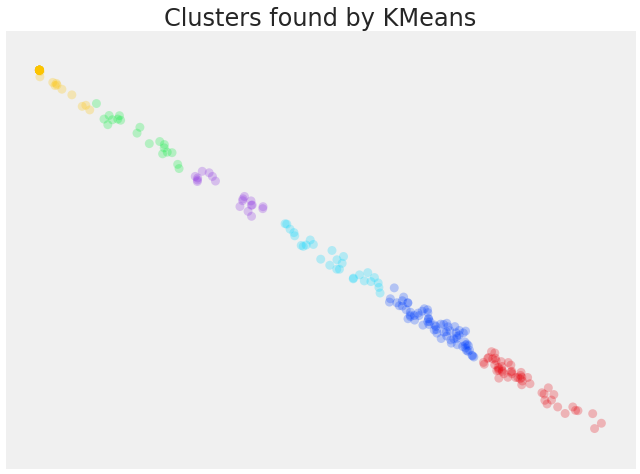

In [190]:
d2v_kmeans=plot_clusters(train_vect, cluster.KMeans, (), {'n_clusters':6})

In [191]:
print('accuracy', metrics.adjusted_rand_score(d2v_kmeans, tra_lbl)) 

('accuracy', 0.05967580649231049)


In [192]:
print('the purity score is ', purity_score(d2v_kmeans,tra_lbl))

('the purity score is ', 0.3059360730593607)


In [193]:
print('Normalize Mutual Information', metrics.normalized_mutual_info_score(d2v_kmeans,tra_lbl))

('Normalize Mutual Information', 0.13230560004683842)


In [194]:
d2v_kmeans=list(d2v_kmeans)
clusters_doc2vec=set(d2v_kmeans)
for i in clusters_doc2vec:
    print(i,d2v_kmeans.count(i))

(0, 67)
(1, 19)
(2, 51)
(3, 19)
(4, 35)
(5, 28)


In [195]:
uniq_lbl=set(tra_lbl)
for i in uniq_lbl:
    print(i,tra_lbl.count(i))

('NA', 30)
('1', 33)
('0', 60)
('3', 35)
('2', 51)
('5', 1)
('4', 9)
